In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir("..")
from scripts.licence_plate_detection import detect_license_plate
from scripts.character_recognition import character_segmentation, predict_characters

In [2]:
license_plates = []
for image_file in os.listdir("dataset/sampleplates"):
    image_path = os.path.join("dataset/sampleplates", image_file)
    image = cv2.imread(image_path)
    
    image = cv2.resize(image, (640, 480))
    license_plate = detect_license_plate(image)
    if license_plate:
        for contour in license_plate:
            x, y, w, h = cv2.boundingRect(contour)
            license_plates.append(image[y:y+h, x:x+w])

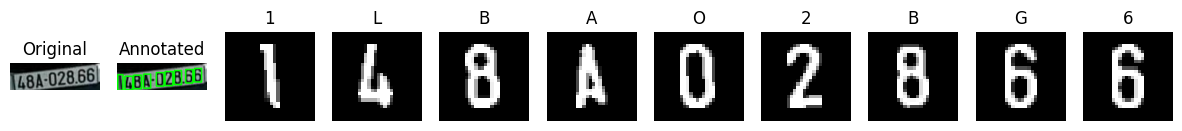

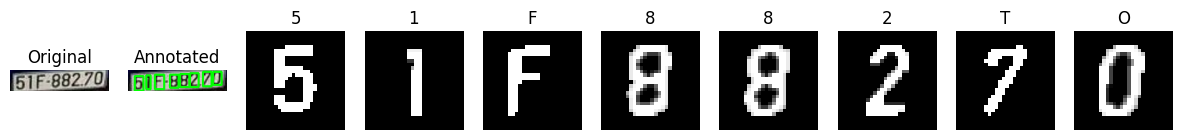

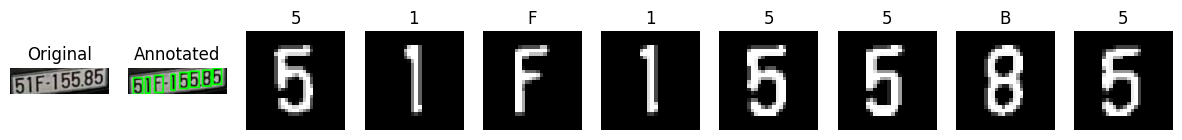

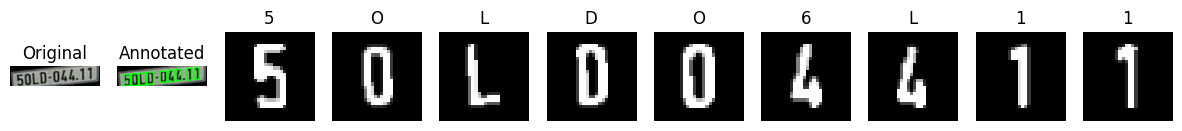

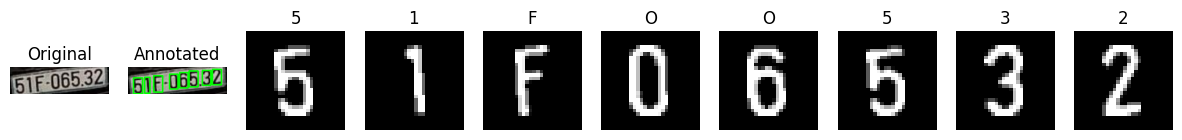

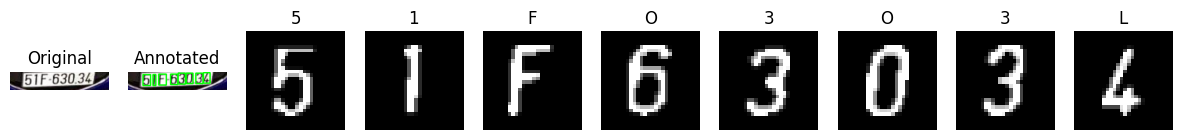

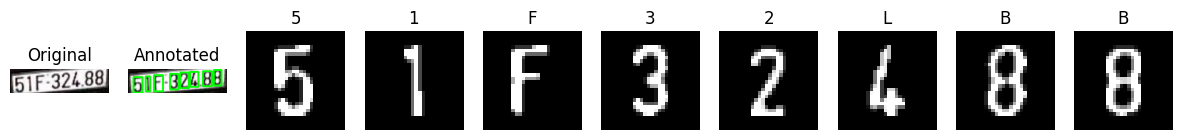

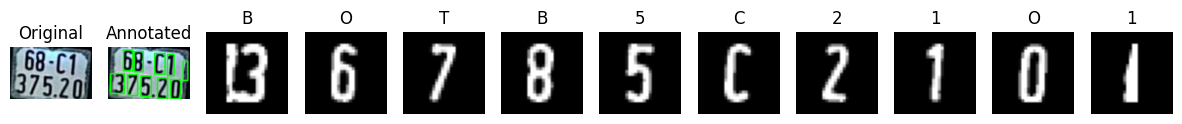

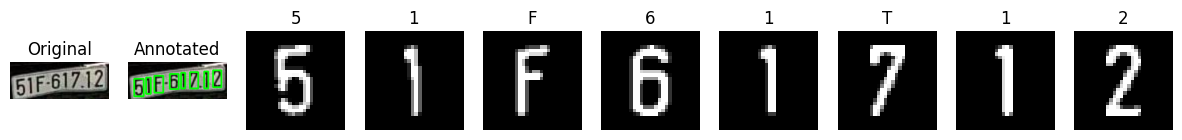

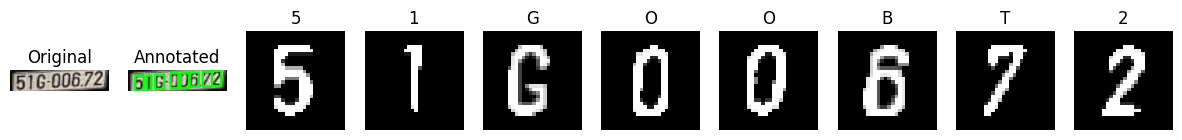

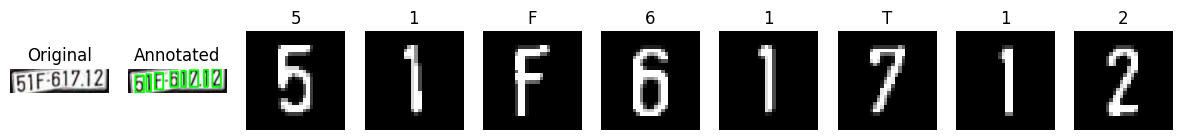

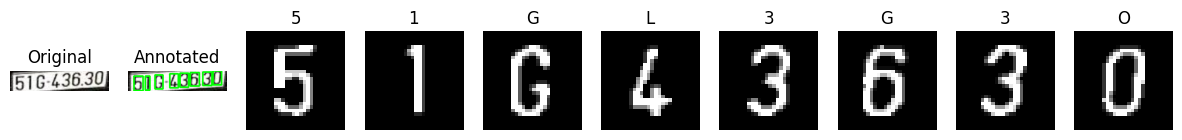

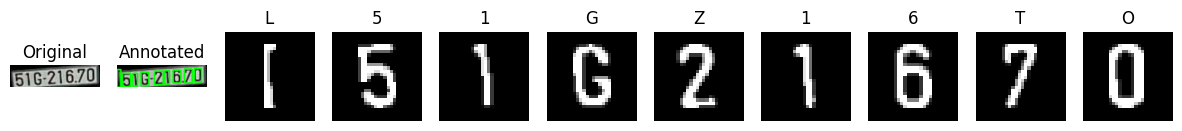

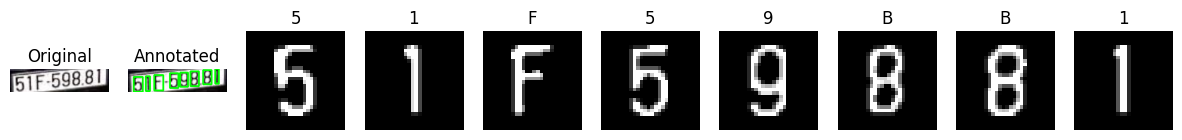

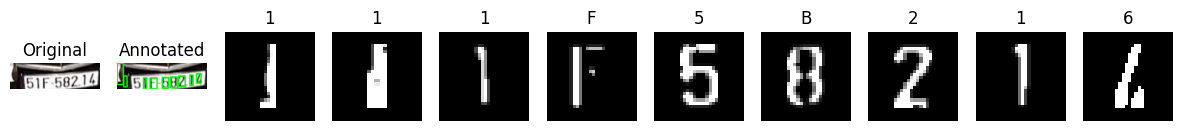

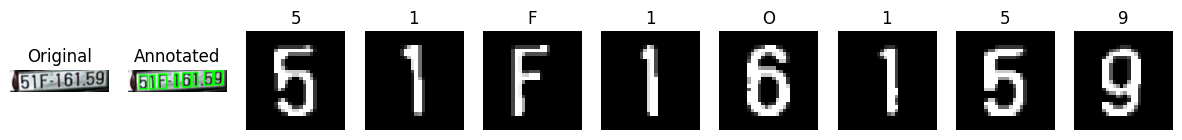

In [3]:
for index, plate in enumerate(license_plates):
    annotated, char_images = character_segmentation(plate)

    len_cols = len(char_images) + 2
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len_cols, 1)
    plt.imshow(plate)
    plt.axis('off')
    plt.title('Original')

    plt.subplot(1, len_cols, 2)
    plt.imshow(annotated, cmap='gray')
    plt.axis('off')
    plt.title('Annotated')

    characters = predict_characters(char_images)
    for index, char_image in enumerate(char_images):
        plt.subplot(1, len_cols, index + 3)
        plt.imshow(char_image, cmap='gray')
        plt.axis('off')
        plt.title(characters[index][0])
    plt.show()